# Import Required Libraries
Import necessary libraries including NumPy, Pandas, Matplotlib, Scikit-learn, and TensorFlow.

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# Load Dataset
Define a function to load the X-ray dataset from the given directory structure.

In [2]:
def load_path(path):
    """
    Load X-ray dataset from the given directory structure.
    """
    dataset = []
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            for body in os.listdir(folder_path):
                body_path = os.path.join(folder_path, body)
                for patient_id in os.listdir(body_path):
                    patient_path = os.path.join(body_path, patient_id)
                    for label_folder in os.listdir(patient_path):
                        label = 'fractured' if label_folder.endswith('positive') else 'normal'
                        label_path = os.path.join(patient_path, label_folder)
                        for img in os.listdir(label_path):
                            img_path = os.path.join(label_path, img)
                            dataset.append({'label': body, 'image_path': img_path})
    return dataset

# Use current working directory
THIS_FOLDER = os.getcwd()
image_dir = os.path.join(THIS_FOLDER, 'dataset')
data = load_path(image_dir)

# Prepare DataFrame
Create a DataFrame from the loaded dataset and add labels for each category.

In [3]:
THIS_FOLDER = os.getcwd()
image_dir = os.path.join(THIS_FOLDER, 'dataset')
data = load_path(image_dir)

labels = []
filepaths = []

Labels = ["Elbow", "Hand", "Shoulder"]
for row in data:
    labels.append(row['label'])
    filepaths.append(row['image_path'])

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)

# Display the first few rows of the DataFrame to verify
images.head()

,Filepath,Label
0,c:\Users\arnav\Documents\Coding\medi-sync\trai...,Elbow
1,c:\Users\arnav\Documents\Coding\medi-sync\trai...,Elbow
2,c:\Users\arnav\Documents\Coding\medi-sync\trai...,Elbow
3,c:\Users\arnav\Documents\Coding\medi-sync\trai...,Elbow
4,c:\Users\arnav\Documents\Coding\medi-sync\trai...,Elbow


# Split Dataset
Split the dataset into training and testing sets, and further split the training set into training and validation sets.

In [4]:
train_df, test_df = train_test_split(images, train_size=0.9, shuffle=True, random_state=1)

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 14641 validated image filenames belonging to 3 classes.
Found 3660 validated image filenames belonging to 3 classes.
Found 2034 validated image filenames belonging to 3 classes.


# Build Model
Build a model using a pre-trained ResNet50 model with additional dense layers.

In [7]:
pretrained_model = tf.keras.applications.ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

inputs = pretrained_model.input
x = pretrained_model.output  # Use the output of the pretrained model
x = tf.keras.layers.Dense(128, activation='relu')(x)  # Call the Dense layer to get its output
x = tf.keras.layers.Dropout(0.3)(x)  # Apply Dropout to the output
x = tf.keras.layers.Dense(50, activation='relu')(x)  # Call the Dense layer to get its output
x = tf.keras.layers.Dropout(0.2)(x)  # Apply Dropout to the output
outputs = tf.keras.layers.Dense(len(Labels), activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

# Train Model
Train the model using the training and validation data, with early stopping to prevent overfitting.

In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(THIS_FOLDER, "weights/ResNet50_BodyParts.h5"),
    monitor='val_loss',
    save_best_only=True
)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=0.0001
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=25,
    callbacks=[checkpoint_callback, reduce_lr_callback, early_stopping_callback]
)

Epoch 1/25
229/229 [==============================] - 288s 1s/step - loss: 0.0857 - accuracy: 0.9688 - val_loss: 0.0318 - val_accuracy: 0.9896 - lr: 0.0010
Epoch 2/25
229/229 [==============================] - 51s 222ms/step - loss: 0.0364 - accuracy: 0.9886 - val_loss: 0.0187 - val_accuracy: 0.9926 - lr: 0.0010
Epoch 3/25
229/229 [==============================] - 52s 226ms/step - loss: 0.0228 - accuracy: 0.9930 - val_loss: 0.0228 - val_accuracy: 0.9921 - lr: 0.0010
Epoch 4/25
229/229 [==============================] - 52s 225ms/step - loss: 0.0283 - accuracy: 0.9915 - val_loss: 0.0228 - val_accuracy: 0.9921 - lr: 0.0010
Epoch 5/25
229/229 [==============================] - 47s 206ms/step - loss: 0.0112 - accuracy: 0.9960 - val_loss: 0.0167 - val_accuracy: 0.9937 - lr: 2.0000e-04
Epoch 6/25
229/229 [==============================] - 53s 232ms/step - loss: 0.0087 - accuracy: 0.9970 - val_loss: 0.0183 - val_accuracy: 0.9943 - lr: 2.0000e-04
Epoch 7/25
229/229 [==========================

# Evaluate Model
Evaluate the model on the test data and print the test accuracy.

In [10]:
results = model.evaluate(test_images, verbose=0)
print(results)
print(f"Test Accuracy: {np.round(results[1] * 100, 2)}%")

[0.026022274047136307, 0.9941002726554871]
Test Accuracy: 99.41%


# Plot Accuracy and Loss
Plot the accuracy and loss for both training and validation sets over the epochs.

[0.026022274047136307, 0.9941002726554871]
Test Accuracy: 99.41%


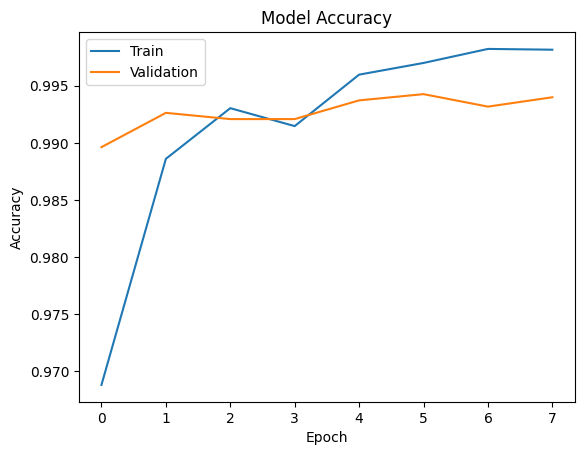

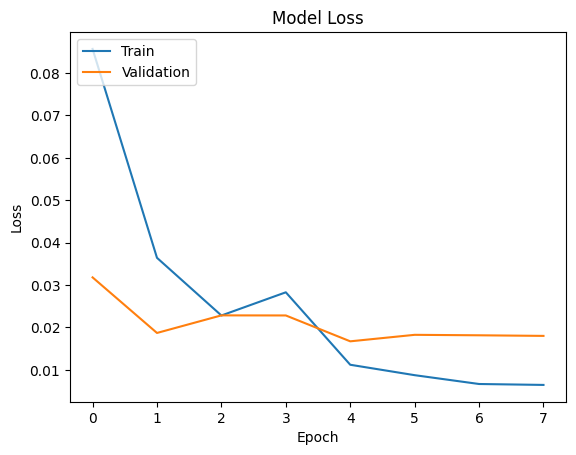

In [11]:
print(results)
print(f"Test Accuracy: {np.round(results[1] * 100, 2)}%")

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()